# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 10, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 10,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'shift_polynomial': False,
        
        'border_min': 0.2, # defines an intervall. Value is randomly chosen and defines the minimum gap between x_min / x_max and the outermost stationary points => two values (left and right gap will be generated per variable)
        'border_max': 0.4,
        'lower_degree_prob': 0.5, # probability that the degree of the whole polynomial will be reduced
        'a_random_prob': 0.5, # probability that a random generated function is used without adjustement
                
        'global_stationary_prob': 1, # probability that all variables are used for adjustement (0 recommended for higher number of variables)
        'bulge_min': 1, # bulge_min and bulge_max define an intervall of how much the function is bulged
        'bulge_max': 4,
        'min_variables_used': 2, # defines an Intervall of how many variables are used to get stationary points and therefore adjust the function
        'max_variables_used': 6,
        'max_monomials': 7, # maximum number of monomials, before adjusting the function (monomial of degree 0 is always defined, but is included in this number)
        'max_monomials_random': 10, #maximum number of monomials for random generated functions
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0,
        'dropout_output': 0,
        'epochs': 2000, 
        'early_stopping': True,
        'early_stopping_patience': None,
        'batch_size': 256,
        'dense_layers': [4096, 2048],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 50000,
                
        'interpretation_net_output_monomials': 10, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': False, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        'max_optimization_minutes': 30,
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 5000,
        
        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': True,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': False,
    },
    'computation':{
        'train_model': True,
        'n_jobs': 10,
        'use_gpu': True,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(2)

from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

import random 

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.6.0'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2, --tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 286
[[3, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 1, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 1, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 1], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 1, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 1], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 2, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 1, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 1], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 2, 0, 0, 0, 

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  2870


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense4096-2048-output_2870_drop0e2000b256_custom/lnets_50000_50-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_10_d_3_negd_0_prob_0_spars_10_amin_-1_amax_1_xdist_uniform_noise_normal_0
lnets_50000_50-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_10_d_3_negd_0_prob_0_spars_10_amin_-1_amax_1_xdist_uniform_noise_normal_0


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed: 11.5min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,3000000000-target,2100000000-target,2010000000-target,2001000000-target,2000100000-target,2000010000-target,2000001000-target,2000000100-target,2000000010-target,2000000001-target,2000000000-target,1200000000-target,1110000000-target,1101000000-target,1100100000-target,1100010000-target,1100001000-target,1100000100-target,1100000010-target,1100000001-target,1100000000-target,1020000000-target,1011000000-target,1010100000-target,1010010000-target,1010001000-target,1010000100-target,1010000010-target,1010000001-target,1010000000-target,1002000000-target,1001100000-target,1001010000-target,1001001000-target,1001000100-target,1001000010-target,1001000001-target,1001000000-target,1000200000-target,1000110000-target,1000101000-target,1000100100-target,1000100010-target,1000100001-target,1000100000-target,1000020000-target,1000011000-target,1000010100-target,1000010010-target,1000010001-target,1000010000-target,1000002000-target,1000001100-target,1000001010-target,1000001001-target,1000001000-target,1000000200-target,1000000110-target,1000000101-target,1000000100-target,1000000020-target,1000000011-target,1000000010-target,1000000002-target,1000000001-target,1000000000-target,0300000000-target,0210000000-target,0201000000-target,0200100000-target,0200010000-target,0200001000-target,0200000100-target,0200000010-target,0200000001-target,0200000000-target,0120000000-target,0111000000-target,0110100000-target,0110010000-target,0110001000-target,0110000100-target,0110000010-target,0110000001-target,0110000000-target,0102000000-target,0101100000-target,0101010000-target,0101001000-target,0101000100-target,0101000010-target,0101000001-target,0101000000-target,0100200000-target,0100110000-target,0100101000-target,0100100100-target,0100100010-target,0100100001-target,0100100000-target,0100020000-target,0100011000-target,0100010100-target,0100010010-target,0100010001-target,0100010000-target,0100002000-target,0100001100-target,0100001010-target,0100001001-target,0100001000-target,0100000200-target,0100000110-target,0100000101-target,0100000100-target,0100000020-target,0100000011-target,0100000010-target,0100000002-target,0100000001-target,0100000000-target,0030000000-target,0021000000-target,0020100000-target,0020010000-target,0020001000-target,0020000100-target,0020000010-target,0020000001-target,0020000000-target,0012000000-target,0011100000-target,0011010000-target,0011001000-target,0011000100-target,0011000010-target,0011000001-target,0011000000-target,0010200000-target,0010110000-target,0010101000-target,0010100100-target,0010100010-target,0010100001-target,0010100000-target,0010020000-target,0010011000-target,0010010100-target,0010010010-target,0010010001-target,0010010000-target,0010002000-target,0010001100-target,0010001010-target,0010001001-target,0010001000-target,0010000200-target,0010000110-target,0010000101-target,0010000100-target,0010000020-target,0010000011-target,0010000010-target,0010000002-target,0010000001-target,0010000000-target,0003000000-target,0002100000-target,0002010000-target,0002001000-target,0002000100-target,0002000010-target,0002000001-target,0002000000-target,0001200000-target,0001110000-target,0001101000-target,0001100100-target,0001100010-target,0001100001-target,0001100000-target,0001020000-target,0001011000-target,0001010100-target,0001010010-target,0001010001-target,0001010000-target,0001002000-target,0001001100-target,0001001010-target,0001001001-target,0001001000-target,0001000200-target,0001000110-target,0001000101-target,0001000100-target,0001000020-target,0001000011-target,0001000010-target,0001000002-target,0001000001-target,0001000000-target,0000300000-target,0000210000-target,0000201000-target,0000200100-target,0000200010-target,0000200001-target,0000200000-target,0000120000-target,0000111000-target,0000110100-target,0000110010-target,0000110001-target,0000110000-target,0000102000-target,0000101100-target,0000101010-target,0000101001-target,0000101000-target,0000100200-target,0000100110-targe

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,3000000000-target,2100000000-target,2010000000-target,2001000000-target,2000100000-target,2000010000-target,2000001000-target,2000000100-target,2000000010-target,2000000001-target,2000000000-target,1200000000-target,1110000000-target,1101000000-target,1100100000-target,1100010000-target,1100001000-target,1100000100-target,1100000010-target,1100000001-target,1100000000-target,1020000000-target,1011000000-target,1010100000-target,1010010000-target,1010001000-target,1010000100-target,1010000010-target,1010000001-target,1010000000-target,1002000000-target,1001100000-target,1001010000-target,1001001000-target,1001000100-target,1001000010-target,1001000001-target,1001000000-target,1000200000-target,1000110000-target,1000101000-target,1000100100-target,1000100010-target,1000100001-target,1000100000-target,1000020000-target,1000011000-target,1000010100-target,1000010010-target,1000010001-target,1000010000-target,1000002000-target,1000001100-target,1000001010-target,1000001001-target,1000001000-target,1000000200-target,1000000110-target,1000000101-target,1000000100-target,1000000020-target,1000000011-target,1000000010-target,1000000002-target,1000000001-target,1000000000-target,0300000000-target,0210000000-target,0201000000-target,0200100000-target,0200010000-target,0200001000-target,0200000100-target,0200000010-target,0200000001-target,0200000000-target,0120000000-target,0111000000-target,0110100000-target,0110010000-target,0110001000-target,0110000100-target,0110000010-target,0110000001-target,0110000000-target,0102000000-target,0101100000-target,0101010000-target,0101001000-target,0101000100-target,0101000010-target,0101000001-target,0101000000-target,0100200000-target,0100110000-target,0100101000-target,0100100100-target,0100100010-target,0100100001-target,0100100000-target,0100020000-target,0100011000-target,0100010100-target,0100010010-target,0100010001-target,0100010000-target,0100002000-target,0100001100-target,0100001010-target,0100001001-target,0100001000-target,0100000200-target,0100000110-target,0100000101-target,0100000100-target,0100000020-target,0100000011-target,0100000010-target,0100000002-target,0100000001-target,0100000000-target,0030000000-target,0021000000-target,0020100000-target,0020010000-target,0020001000-target,0020000100-target,0020000010-target,0020000001-target,0020000000-target,0012000000-target,0011100000-target,0011010000-target,0011001000-target,0011000100-target,0011000010-target,0011000001-target,0011000000-target,0010200000-target,0010110000-target,0010101000-target,0010100100-target,0010100010-target,0010100001-target,0010100000-target,0010020000-target,0010011000-target,0010010100-target,0010010010-target,0010010001-target,0010010000-target,0010002000-target,0010001100-target,0010001010-target,0010001001-target,0010001000-target,0010000200-target,0010000110-target,0010000101-target,0010000100-target,0010000020-target,0010000011-target,0010000010-target,0010000002-target,0010000001-target,0010000000-target,0003000000-target,0002100000-target,0002010000-target,0002001000-target,0002000100-target,0002000010-target,0002000001-target,0002000000-target,0001200000-target,0001110000-target,0001101000-target,0001100100-target,0001100010-target,0001100001-target,0001100000-target,0001020000-target,0001011000-target,0001010100-target,0001010010-target,0001010001-target,0001010000-target,0001002000-target,0001001100-target,0001001010-target,0001001001-target,0001001000-target,0001000200-target,0001000110-target,0001000101-target,0001000100-target,0001000020-target,0001000011-target,0001000010-target,0001000002-target,0001000001-target,0001000000-target,0000300000-target,0000210000-target,0000201000-target,0000200100-target,0000200010-target,0000200001-target,0000200000-target,0000120000-target,0000111000-target,0000110100-target,0000110010-target,0000110001-target,0000110000-target,0000102000-target,0000101100-target,0000101010-target,0000101001-target,0000101000-target,0000100200-target,0000100110-targe

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[7.05915157e-01, 6.27424136e-01, 2.31400764e-02, 3.69228633e-01,
        3.93976383e-01, 5.42979290e-01, 3.50559608e-01, 1.20249068e-01,
        8.87814480e-01, 1.84921226e-01],
       [3.66000488e-01, 4.22827881e-01, 4.73427194e-01, 4.76920219e-01,
        5.59645966e-01, 7.85109405e-01, 2.91205841e-01, 9.39370446e-01,
        4.06682111e-01, 3.24471608e-02],
       [4.09128828e-01, 1.53215290e-01, 2.35599972e-01, 9.95880126e-01,
        8.04528563e-01, 3.15136153e-01, 5.99134375e-01, 9.26189279e-01,
        1.55255961e-01, 9.49833970e-01],
       [8.15820084e-01, 8.53761090e-01, 5.96854502e-01, 4.66140691e-01,
        3.54703397e-01, 5.71349610e-01, 8.92274012e-01, 3.60118852e-02,
        5.97336602e-01, 5.18454712e-01],
       [8.25211803e-01, 6.81649808e-01, 8.32933068e-01, 2.84276584e-01,
        1.54202319e-01, 7.78798266e-01, 8.60080258e-01, 4.86106226e-01,
        3.62074064e-01, 9.99640259e-01],
       [8.54697269e-01, 8.95330725e-01, 6.67125320e-01, 2.52795799e-01,
   

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[ 0.05780073],
       [-0.55014724],
       [ 0.13309953],
       [-0.46402583],
       [-1.01678252],
       [-0.29628071],
       [-0.14892277],
       [ 0.48231304],
       [-0.67929465],
       [-0.20982581]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_dataset_without_noise, test_split=0.1)

            _, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(44910, 1460)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(4990, 1460)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 1460)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,3000000000-target,2100000000-target,2010000000-target,2001000000-target,2000100000-target,2000010000-target,2000001000-target,2000000100-target,2000000010-target,2000000001-target,2000000000-target,1200000000-target,1110000000-target,1101000000-target,1100100000-target,1100010000-target,1100001000-target,1100000100-target,1100000010-target,1100000001-target,1100000000-target,1020000000-target,1011000000-target,1010100000-target,1010010000-target,1010001000-target,1010000100-target,1010000010-target,1010000001-target,1010000000-target,1002000000-target,1001100000-target,1001010000-target,1001001000-target,1001000100-target,1001000010-target,1001000001-target,1001000000-target,1000200000-target,1000110000-target,1000101000-target,1000100100-target,1000100010-target,1000100001-target,1000100000-target,1000020000-target,1000011000-target,1000010100-target,1000010010-target,1000010001-target,1000010000-target,1000002000-target,1000001100-target,1000001010-target,1000001001-target,1000001000-target,1000000200-target,1000000110-target,1000000101-target,1000000100-target,1000000020-target,1000000011-target,1000000010-target,1000000002-target,1000000001-target,1000000000-target,0300000000-target,0210000000-target,0201000000-target,0200100000-target,0200010000-target,0200001000-target,0200000100-target,0200000010-target,0200000001-target,0200000000-target,0120000000-target,0111000000-target,0110100000-target,0110010000-target,0110001000-target,0110000100-target,0110000010-target,0110000001-target,0110000000-target,0102000000-target,0101100000-target,0101010000-target,0101001000-target,0101000100-target,0101000010-target,0101000001-target,0101000000-target,0100200000-target,0100110000-target,0100101000-target,0100100100-target,0100100010-target,0100100001-target,0100100000-target,0100020000-target,0100011000-target,0100010100-target,0100010010-target,0100010001-target,0100010000-target,0100002000-target,0100001100-target,0100001010-target,0100001001-target,0100001000-target,0100000200-target,0100000110-target,0100000101-target,0100000100-target,0100000020-target,0100000011-target,0100000010-target,0100000002-target,0100000001-target,0100000000-target,0030000000-target,0021000000-target,0020100000-target,0020010000-target,0020001000-target,0020000100-target,0020000010-target,0020000001-target,0020000000-target,0012000000-target,0011100000-target,0011010000-target,0011001000-target,0011000100-target,0011000010-target,0011000001-target,0011000000-target,0010200000-target,0010110000-target,0010101000-target,0010100100-target,0010100010-target,0010100001-target,0010100000-target,0010020000-target,0010011000-target,0010010100-target,0010010010-target,0010010001-target,0010010000-target,0010002000-target,0010001100-target,0010001010-target,0010001001-target,0010001000-target,0010000200-target,0010000110-target,0010000101-target,0010000100-target,0010000020-target,0010000011-target,0010000010-target,0010000002-target,0010000001-target,0010000000-target,0003000000-target,0002100000-target,0002010000-target,0002001000-target,0002000100-target,0002000010-target,0002000001-target,0002000000-target,0001200000-target,0001110000-target,0001101000-target,0001100100-target,0001100010-target,0001100001-target,0001100000-target,0001020000-target,0001011000-target,0001010100-target,0001010010-target,0001010001-target,0001010000-target,0001002000-target,0001001100-target,0001001010-target,0001001001-target,0001001000-target,0001000200-target,0001000110-target,0001000101-target,0001000100-target,0001000020-target,0001000011-target,0001000010-target,0001000002-target,0001000001-target,0001000000-target,0000300000-target,0000210000-target,0000201000-target,0000200100-target,0000200010-target,0000200001-target,0000200000-target,0000120000-target,0000111000-target,0000110100-target,0000110010-target,0000110001-target,0000110000-target,0000102000-target,0000101100-target,0000101010-target,0000101001-target,0000101000-target,0000100200-target,0000100110-targe

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,3000000000-target,2100000000-target,2010000000-target,2001000000-target,2000100000-target,2000010000-target,2000001000-target,2000000100-target,2000000010-target,2000000001-target,2000000000-target,1200000000-target,1110000000-target,1101000000-target,1100100000-target,1100010000-target,1100001000-target,1100000100-target,1100000010-target,1100000001-target,1100000000-target,1020000000-target,1011000000-target,1010100000-target,1010010000-target,1010001000-target,1010000100-target,1010000010-target,1010000001-target,1010000000-target,1002000000-target,1001100000-target,1001010000-target,1001001000-target,1001000100-target,1001000010-target,1001000001-target,1001000000-target,1000200000-target,1000110000-target,1000101000-target,1000100100-target,1000100010-target,1000100001-target,1000100000-target,1000020000-target,1000011000-target,1000010100-target,1000010010-target,1000010001-target,1000010000-target,1000002000-target,1000001100-target,1000001010-target,1000001001-target,1000001000-target,1000000200-target,1000000110-target,1000000101-target,1000000100-target,1000000020-target,1000000011-target,1000000010-target,1000000002-target,1000000001-target,1000000000-target,0300000000-target,0210000000-target,0201000000-target,0200100000-target,0200010000-target,0200001000-target,0200000100-target,0200000010-target,0200000001-target,0200000000-target,0120000000-target,0111000000-target,0110100000-target,0110010000-target,0110001000-target,0110000100-target,0110000010-target,0110000001-target,0110000000-target,0102000000-target,0101100000-target,0101010000-target,0101001000-target,0101000100-target,0101000010-target,0101000001-target,0101000000-target,0100200000-target,0100110000-target,0100101000-target,0100100100-target,0100100010-target,0100100001-target,0100100000-target,0100020000-target,0100011000-target,0100010100-target,0100010010-target,0100010001-target,0100010000-target,0100002000-target,0100001100-target,0100001010-target,0100001001-target,0100001000-target,0100000200-target,0100000110-target,0100000101-target,0100000100-target,0100000020-target,0100000011-target,0100000010-target,0100000002-target,0100000001-target,0100000000-target,0030000000-target,0021000000-target,0020100000-target,0020010000-target,0020001000-target,0020000100-target,0020000010-target,0020000001-target,0020000000-target,0012000000-target,0011100000-target,0011010000-target,0011001000-target,0011000100-target,0011000010-target,0011000001-target,0011000000-target,0010200000-target,0010110000-target,0010101000-target,0010100100-target,0010100010-target,0010100001-target,0010100000-target,0010020000-target,0010011000-target,0010010100-target,0010010010-target,0010010001-target,0010010000-target,0010002000-target,0010001100-target,0010001010-target,0010001001-target,0010001000-target,0010000200-target,0010000110-target,0010000101-target,0010000100-target,0010000020-target,0010000011-target,0010000010-target,0010000002-target,0010000001-target,0010000000-target,0003000000-target,0002100000-target,0002010000-target,0002001000-target,0002000100-target,0002000010-target,0002000001-target,0002000000-target,0001200000-target,0001110000-target,0001101000-target,0001100100-target,0001100010-target,0001100001-target,0001100000-target,0001020000-target,0001011000-target,0001010100-target,0001010010-target,0001010001-target,0001010000-target,0001002000-target,0001001100-target,0001001010-target,0001001001-target,0001001000-target,0001000200-target,0001000110-target,0001000101-target,0001000100-target,0001000020-target,0001000011-target,0001000010-target,0001000002-target,0001000001-target,0001000000-target,0000300000-target,0000210000-target,0000201000-target,0000200100-target,0000200010-target,0000200001-target,0000200000-target,0000120000-target,0000111000-target,0000110100-target,0000110010-target,0000110001-target,0000110000-target,0000102000-target,0000101100-target,0000101010-target,0000101001-target,0000101000-target,0000100200-target,0000100110-targe

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,3000000000-target,2100000000-target,2010000000-target,2001000000-target,2000100000-target,2000010000-target,2000001000-target,2000000100-target,2000000010-target,2000000001-target,2000000000-target,1200000000-target,1110000000-target,1101000000-target,1100100000-target,1100010000-target,1100001000-target,1100000100-target,1100000010-target,1100000001-target,1100000000-target,1020000000-target,1011000000-target,1010100000-target,1010010000-target,1010001000-target,1010000100-target,1010000010-target,1010000001-target,1010000000-target,1002000000-target,1001100000-target,1001010000-target,1001001000-target,1001000100-target,1001000010-target,1001000001-target,1001000000-target,1000200000-target,1000110000-target,1000101000-target,1000100100-target,1000100010-target,1000100001-target,1000100000-target,1000020000-target,1000011000-target,1000010100-target,1000010010-target,1000010001-target,1000010000-target,1000002000-target,1000001100-target,1000001010-target,1000001001-target,1000001000-target,1000000200-target,1000000110-target,1000000101-target,1000000100-target,1000000020-target,1000000011-target,1000000010-target,1000000002-target,1000000001-target,1000000000-target,0300000000-target,0210000000-target,0201000000-target,0200100000-target,0200010000-target,0200001000-target,0200000100-target,0200000010-target,0200000001-target,0200000000-target,0120000000-target,0111000000-target,0110100000-target,0110010000-target,0110001000-target,0110000100-target,0110000010-target,0110000001-target,0110000000-target,0102000000-target,0101100000-target,0101010000-target,0101001000-target,0101000100-target,0101000010-target,0101000001-target,0101000000-target,0100200000-target,0100110000-target,0100101000-target,0100100100-target,0100100010-target,0100100001-target,0100100000-target,0100020000-target,0100011000-target,0100010100-target,0100010010-target,0100010001-target,0100010000-target,0100002000-target,0100001100-target,0100001010-target,0100001001-target,0100001000-target,0100000200-target,0100000110-target,0100000101-target,0100000100-target,0100000020-target,0100000011-target,0100000010-target,0100000002-target,0100000001-target,0100000000-target,0030000000-target,0021000000-target,0020100000-target,0020010000-target,0020001000-target,0020000100-target,0020000010-target,0020000001-target,0020000000-target,0012000000-target,0011100000-target,0011010000-target,0011001000-target,0011000100-target,0011000010-target,0011000001-target,0011000000-target,0010200000-target,0010110000-target,0010101000-target,0010100100-target,0010100010-target,0010100001-target,0010100000-target,0010020000-target,0010011000-target,0010010100-target,0010010010-target,0010010001-target,0010010000-target,0010002000-target,0010001100-target,0010001010-target,0010001001-target,0010001000-target,0010000200-target,0010000110-target,0010000101-target,0010000100-target,0010000020-target,0010000011-target,0010000010-target,0010000002-target,0010000001-target,0010000000-target,0003000000-target,0002100000-target,0002010000-target,0002001000-target,0002000100-target,0002000010-target,0002000001-target,0002000000-target,0001200000-target,0001110000-target,0001101000-target,0001100100-target,0001100010-target,0001100001-target,0001100000-target,0001020000-target,0001011000-target,0001010100-target,0001010010-target,0001010001-target,0001010000-target,0001002000-target,0001001100-target,0001001010-target,0001001001-target,0001001000-target,0001000200-target,0001000110-target,0001000101-target,0001000100-target,0001000020-target,0001000011-target,0001000010-target,0001000002-target,0001000001-target,0001000000-target,0000300000-target,0000210000-target,0000201000-target,0000200100-target,0000200010-target,0000200001-target,0000200000-target,0000120000-target,0000111000-target,0000110100-target,0000110010-target,0000110001-target,0000110000-target,0000102000-target,0000101100-target,0000101010-target,0000101001-target,0000101000-target,0000100200-target,0000100110-targe

## Interpretation Network Training

In [23]:
%load_ext autoreload

In [24]:
lambda_net_train_dataset_list[0].weight_list[0].shape

(601,)

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/2000
176/176 [==============================] - 125s 655ms/step - loss: 0.2664 - r2_inet_lambda_fv_loss: 0.0652 - val_loss: 0.2558 - val_r2_inet_lambda_fv_loss: -0.0240
Epoch 2/2000
176/176 [==============================] - 115s 656ms/step - loss: 0.2519 - r2_inet_lambda_fv_loss: -0.0546 - val_loss: 0.2514 - val_r2_inet_lambda_fv_loss: -0.0520
Epoch 3/2000
176/176 [==============================] - 115s 651ms/step - loss: 0.2487 - r2_inet_lambda_fv_loss: -0.0776 - val_loss: 0.2585 - val_r2_inet_lambda_fv_loss: 0.0121
Epoch 4/2000
176/176 [==============================] - 114s 651ms/step - loss: 0.2495 - r2_inet_lambda_fv_loss: -0.0730 - val_loss: 0.2518 - val_r2_inet_lambda_fv_loss: -0.0482
Epoch 5/2000
176/176 [==============================] - 115s 651ms/step - loss: 0.2474 - r2_inet_lambda_fv_loss: -0.0879 - val_loss: 0.2488 - val_r2_inet_lambda_fv_lo

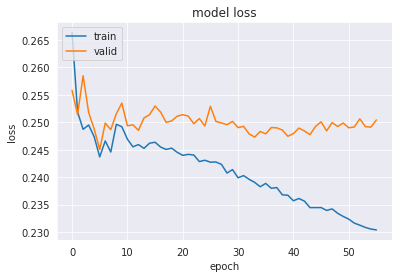

In [25]:
%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



In [26]:
model_list[-1].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 601)]        0                                            
__________________________________________________________________________________________________
hidden1_4096 (Dense)            (None, 4096)         2465792     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 4096)         0           hidden1_4096[0][0]               
__________________________________________________________________________________________________
hidden2_2048 (Dense)            (None, 2048)         8390656     activation1_relu[0][0]           
______________________________________________________________________________________________

In [27]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  


for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)


In [28]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred


end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [29]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [30]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
%autoreload 2
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
100%|██████████| 10/10 [11:09<00:00, 66.99s/it][Paral


100%|██████████| 10/10 [11:01<00:00, 66.13s/it][Parallel(n_jobs=10)]: Done  11 tasks      | elapsed: 43.0min

100%|██████████| 10/10 [10:56<00:00, 65.66s/it][Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 43.3min

100%|██████████| 10/10 [11:37<00:00, 69.77s/it][Parallel(n_jobs=10)]: Done  13 tasks      | elapsed: 43.8min

100%|██████████| 10/10 [11:48<00:00, 70.88s/it][Parallel(n_jobs=10)]: Done  16 tasks      | elapsed: 44.2min

 10%|█         | 1/10 [29:59<4:29:58, 1799.83s/it][Parallel(n_jobs=10)]: Done  17 tasks      | elapsed: 51.7min

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [11:14<00:00, 67.43s/it][Parallel(n_jobs=10)]: Done  18 tasks      | elapsed: 52.8min

100%|██████████| 10/10 [11:16<00:00, 67.63s/it][Parallel(n_jobs=10)]: Done  20 tasks      | elapsed: 53.5min

100%|██████████| 10/10 [11:15<00:00, 67.52s/it][Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 64.5min

100%|██████████| 10/10 [11:28<00:00, 68.88s/it][Parallel(n_jobs=10)]: Done  23 tasks      | elapsed: 65.1min

100%|██████████| 10/10 [11:26<00:00, 68.65s/it][Parallel(n_jobs=10)]: Done  24 tasks      | elapsed: 65.2min

100%|██████████| 10/10 [11:43<00:00, 70.37s/it][Parallel(n_jobs=10)]: Done  26 tasks      | elapsed: 73.6min

 50%|█████     | 5/10 [29:59<29:59, 359.96s/it][Parallel(n_jobs=10)]: Done  27 tasks      | elapsed: 73.8min



100%|██████████| 10/10 [11:48<00:00, 70.82s/it]
[Parallel(n_jobs=10)]: Done  28 tasks      | elapsed: 74.8min
100%|██████████| 10/10 [11:48<00:00, 70.87s/it][Parallel(n_jobs=10)]: Done  29 tasks      | elapsed: 75.6min

100%|██████████| 10/10 [11:40<00:00, 70.05s/it][Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 76.1min

100%|██████████| 10/10 [11:24<00:00, 68.46s/it]
[Parallel(n_jobs=10)]: Done  31 tasks      | elapsed: 86.5min
100%|██████████| 10/10 [11:08<00:00, 66.85s/it]
[Parallel(n_jobs=10)]: Done  33 tasks      | elapsed: 87.5min
100%|██████████| 10/10 [11:25<00:00, 68.54s/it]
[Parallel(n_jobs=10)]: Done  34 tasks      | elapsed: 87.7min
 70%|███████   | 7/10 [29:59<12:51, 257.11s/it][Parallel(n_jobs=10)]: Done  35 tasks      | elapsed: 94.5min

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [11:51<00:00, 71.16s/it][Parallel(n_jobs=10)]: Done  36 tasks      | elapsed: 96.9min

100%|██████████| 10/10 [11:45<00:00, 70.51s/it][Parallel(n_jobs=10)]: Done  37 tasks      | elapsed: 97.7min

100%|██████████| 10/10 [12:03<00:00, 72.32s/it][Parallel(n_jobs=10)]: Done  38 tasks      | elapsed: 97.7min

100%|██████████| 10/10 [11:33<00:00, 69.40s/it][Parallel(n_jobs=10)]: Done  39 tasks      | elapsed: 98.7min

 60%|██████    | 6/10 [29:59<19:59, 299.97s/it][Parallel(n_jobs=10)]: Done  40 tasks      | elapsed: 103.8min

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [11:15<00:00, 67.51s/it]
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed: 108.7min
100%|██████████| 10/10 [11:49<00:00, 70.96s/it][Parallel(n_jobs=10)]: Done  42 tasks      | elapsed: 109.8min

100%|██████████| 10/10 [11:13<00:00, 67.38s/it][Parallel(n_jobs=10)]: Done  43 tasks      | elapsed: 110.2min

  0%|          | 0/10 [29:59<?, ?it/s][Parallel(n_jobs=10)]: Done  44 tasks      | elapsed: 116.5min

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [11:47<00:00, 70.75s/it][Parallel(n_jobs=10)]: Done  45 tasks      | elapsed: 117.1min

100%|██████████| 10/10 [12:01<00:00, 72.12s/it][Parallel(n_jobs=10)]: Done  46 tasks      | elapsed: 118.9min

100%|██████████| 10/10 [11:54<00:00, 71.44s/it][Parallel(n_jobs=10)]: Done  47 tasks      | elapsed: 119.4min

100%|██████████| 10/10 [11:56<00:00, 71.63s/it][Parallel(n_jobs=10)]: Done  48 tasks      | elapsed: 119.8min

100%|██████████| 10/10 [11:41<00:00, 70.17s/it][Parallel(n_jobs=10)]: Done  49 tasks      | elapsed: 121.1min

100%|██████████| 10/10 [11:14<00:00, 67.41s/it][Parallel(n_jobs=10)]: Done  50 tasks      | elapsed: 125.2min

100%|██████████| 10/10 [11:24<00:00, 68.41s/it][Parallel(n_jobs=10)]: Done  51 tasks      | elapsed: 130.7min

100%|██████████| 10/10 [11:14<00:00, 67.48s/it][Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 132.9min

100%|██████████| 10/10 [11:31<00:00, 69.17s/it]
[Parallel(n_jobs=10)]: Done  53 tasks      | elapsed: 133.0min
1

100%|██████████| 10/10 [11:15<00:00, 67.58s/it][Parallel(n_jobs=10)]: Done  61 tasks      | elapsed: 153.0min

100%|██████████| 10/10 [11:03<00:00, 66.32s/it][Parallel(n_jobs=10)]: Done  62 tasks      | elapsed: 154.1min

100%|██████████| 10/10 [10:58<00:00, 65.89s/it][Parallel(n_jobs=10)]: Done  63 tasks      | elapsed: 160.4min

100%|██████████| 10/10 [11:43<00:00, 70.39s/it]
[Parallel(n_jobs=10)]: Done  64 tasks      | elapsed: 161.4min
 40%|████      | 4/10 [29:59<44:59, 449.95s/it][Parallel(n_jobs=10)]: Done  65 tasks      | elapsed: 163.0min

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [11:55<00:00, 71.54s/it][Parallel(n_jobs=10)]: Done  66 tasks      | elapsed: 163.1min

100%|██████████| 10/10 [11:47<00:00, 70.80s/it][Parallel(n_jobs=10)]: Done  67 tasks      | elapsed: 163.8min

100%|██████████| 10/10 [11:53<00:00, 71.39s/it][Parallel(n_jobs=10)]: Done  68 tasks      | elapsed: 165.1min

100%|██████████| 10/10 [11:24<00:00, 68.41s/it][Parallel(n_jobs=10)]: Done  69 tasks      | elapsed: 169.7min

100%|██████████| 10/10 [11:34<00:00, 69.42s/it][Parallel(n_jobs=10)]: Done  70 tasks      | elapsed: 174.0min

100%|██████████| 10/10 [11:24<00:00, 68.48s/it][Parallel(n_jobs=10)]: Done  71 tasks      | elapsed: 174.7min

100%|██████████| 10/10 [11:39<00:00, 70.00s/it][Parallel(n_jobs=10)]: Done  72 tasks      | elapsed: 177.3min

100%|██████████| 10/10 [11:28<00:00, 68.87s/it][Parallel(n_jobs=10)]: Done  73 tasks      | elapsed: 181.8min

100%|██████████| 10/10 [11:59<00:00, 71.99s/it][Parallel(n_jobs=10)]: Done  74 tasks      | elapsed: 184.3min

1


100%|██████████| 10/10 [10:30<00:00, 63.06s/it][Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 241.0min finished


Metamodel Optimization Time: 4:01:02
---------------------------------------------------------------------------------------------------------------------------


In [32]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [ ]:
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:  5.5min
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed: 30.0min



[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed: 30.1min
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed: 30.1min



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed: 30.9min
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed: 30.9min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed: 30.9min
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed: 30.9min
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed: 30.9min
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed: 32.2min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 33.1min


-X7*(X0*X2*X5 + X0*X6 + (X6 + X7)*(0.328620848*X8 + 0.305946009488))



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed: 35.5min


0.419*X3*X6**2 + 0.419*X3*(X6 - X9**3) - X4*X5*(0.567*X0*X1 - 0.567*X6 + X8 + 0.384426)



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed: 36.1min
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed: 59.1min
[Parallel(n_jobs=10)]: Done  16 tasks      | elapsed: 60.2min
[Parallel(n_jobs=10)]: Done  17 tasks      | elapsed: 60.2min
[Parallel(n_jobs=10)]: Done  18 tasks      | elapsed: 60.2min
[Parallel(n_jobs=10)]: Done  19 tasks      | elapsed: 60.9min
[Parallel(n_jobs=10)]: Done  20 tasks      | elapsed: 60.9min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 60.9min


Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed: 62.0min
[Parallel(n_jobs=10)]: Done  23 tasks      | elapsed: 62.2min
[Parallel(n_jobs=10)]: Done  24 tasks      | elapsed: 62.7min
[Parallel(n_jobs=10)]: Done  25 tasks      | elapsed: 66.1min
[Parallel(n_jobs=10)]: Done  26 tasks      | elapsed: 66.1min
[Parallel(n_jobs=10)]: Done  27 tasks      | elapsed: 67.2min
[Parallel(n_jobs=10)]: Done  28 tasks      | elapsed: 89.1min



0.128*X0*X4 - 0.064*X1 + 0.064*X2*X4*(X0 + X5) + 0.064*X2*X4*(-X1*X6 + X2 + X5) - 0.064*X2 + 0.064*X3*(X0*(X0*X3 + X0*(0.064*X0 + X2 + X5) + X0 + X5) - X5) + 0.064*X3 - 0.128*X5 + 0.064*X7*(X0*X4 - X2 - X7*(X0*(X1*X6 - X2*X4 + 3*X2 - X4 - X5 + X8*((X0*(X1*X6 + 0.627*X5 + X7 + X8 - 0.124) - X5)*(X2*X4 + X2 + X8 - X9 - 0.124) - 0.124) - X8 + (X0 + X5)*(0.188*X0 + 0.376*X2 + 0.188*X5 + ((2*X0*(X5 + 2*X7) - X5)*(X2*X4 - 0.248) - 0.124)*(X0*X4 + X2*(0.064*X0 + X2) - X2) + 0.124)) + X2 - X5 - 2*X8) + X8) - 0.192*X8 + 0.192*X9 - (0.627*X5 + X8)*(X5 - 0.373) + (X0*X4 + X2*X4 - X2)*(0.188*X0*(X5 + 2*X7 - 0.252) - 0.188*X5 + 0.124) - 0.023872



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=10)]: Done  29 tasks      | elapsed: 90.2min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 90.2min
[Parallel(n_jobs=10)]: Done  31 tasks      | elapsed: 90.9min
[Parallel(n_jobs=10)]: Done  32 tasks      | elapsed: 90.9min
[Parallel(n_jobs=10)]: Done  33 tasks      | elapsed: 92.0min
[Parallel(n_jobs=10)]: Done  34 tasks      | elapsed: 92.2min
[Parallel(n_jobs=10)]: Done  35 tasks      | elapsed: 92.2min



X2*(X0*X8 + 0.887364*X2)




[Parallel(n_jobs=10)]: Done  36 tasks      | elapsed: 92.2min
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=10)]: Done  37 tasks      | elapsed: 92.7min


X7*(X2 + X5**2*X8 + X5)



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=10)]: Done  38 tasks      | elapsed: 96.1min
[Parallel(n_jobs=10)]: Done  39 tasks      | elapsed: 97.2min
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed: 97.8min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed: 100.2min
[Parallel(n_jobs=10)]: Done  42 tasks      | elapsed: 119.3min
[Parallel(n_jobs=10)]: Done  43 tasks      | elapsed: 120.2min


[Parallel(n_jobs=10)]: Done  44 tasks      | elapsed: 120.2min
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=10)]: Done  45 tasks      | elapsed: 122.2min
[Parallel(n_jobs=10)]: Done  46 tasks      | elapsed: 122.3min
[Parallel(n_jobs=10)]: Done  47 tasks      | elapsed: 122.4min
[Parallel(n_jobs=10)]: Done  48 tasks      | elapsed: 122.8min
[Parallel(n_jobs=10)]: Done  49 tasks      | elapsed: 126.1min
[Parallel(n_jobs=10)]: Done  50 tasks      | elapsed: 127.2min


X0**2*X7 + 0.177*X0*X8**2 + 0.177*X0*X8 + 0.177*X3*X7 - X5**2*X6 - X9**2

X2**2 - X6*X8




Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=10)]: Done  51 tasks      | elapsed: 128.0min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 130.2min
[Parallel(n_jobs=10)]: Done  53 tasks      | elapsed: 132.3min


In [ ]:
#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

In [ ]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []

for function_values_test, polynomial_dict_test in zip(function_values_test_list, polynomial_dict_test_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


In [ ]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_list=scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [ ]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [ ]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

In [ ]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [ ]:
#0.183	0.234	3.604	0.143	0.687	2.559	0.215

In [ ]:
scores_test_list[-1]

In [ ]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'].values

In [ ]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'].values

In [ ]:
distrib_dict_test_list[-1]['MAE']

In [ ]:
distrib_dict_test_list[-1]['R2']

In [ ]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

In [ ]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



In [ ]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



In [ ]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


In [ ]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


In [ ]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


In [ ]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


In [ ]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    try:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    except:
        pass
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [ ]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    try:
        plt.plot(history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [ ]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [ ]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [ ]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [ ]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [ ]:
STOP

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()